<table>
    <tr>
        <td><img src='SystemLink_icon.png' /></td>
        <td ><h1><strong>NI SystemLink Python API</strong></h1></td>
    </tr>
</table>

## Tag Service Example
***
The Tag Service API provides functions to create, update, and query current values/metada of **SystemLink** tags.
***
# Prerequisites
- None

# Summary 
This example uses the Tag Service API to get the values of a few built-in tags used for monitoring system health.

- Query the CPU, Memory and Disk usage (%) tags
- Visualize the values in table format
- Visualize the current, min and max values using error bars
- Query the CPU usage (%) per CPU
- Visualize the CPU usage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import systemlink.clients.nitag as nitag
from systemlink.clients.nitaghistorian.api.history_api import HistoryApi
from systemlink.clients.nitaghistorian.models.http_query_request_body import HttpQueryRequestBody

tags_api = nitag.TagsApi()
tag_list = 'localhost.Health.CPU.MeanUsePercentage,localhost.Health.Memory.UsePercentage,localhost.Health.Disk.UsePercentage'

# Get the tags for CPU, Memory and Disk usage (%)
cpu_usage, memory_usage, disk_usage = (await tags_api.get_tags_with_values(path=tag_list)).tags_with_values

# Visualize Resource Utilization (CPU, Memory, Disk)

Format the current, mean, min and max values for each category in a **Pandas Dataframe**. Visualize the Dataframe as a table.

In [2]:
# Visualize the tags values, in table format

current_values = np.array([float(disk_usage.current.value.value), float(memory_usage.current.value.value), float(cpu_usage.current.value.value)])
min_values = np.array([float(disk_usage.aggregates.min), float(memory_usage.aggregates.min), float(cpu_usage.aggregates.min)])
max_values = np.array([float(disk_usage.aggregates.max), float(memory_usage.aggregates.max), float(cpu_usage.aggregates.max)])
mean_values = np.array([float(disk_usage.aggregates.avg), float(memory_usage.aggregates.avg), float(cpu_usage.aggregates.avg)])

df = pd.DataFrame([current_values, min_values, max_values, mean_values], columns=['CPU', 'Memory', 'Disk'], index=['Current', 'Min', 'Max', 'Mean'])
df

,CPU,Memory,Disk
Current,80.124000,70.982835,7.40000
Min,14.982278,41.791659,0.00000
Max,99.987023,99.867083,100.00000
Mean,67.391514,64.466894,10.73256


# Errorbar Plot
Plot the tags current values, with error bars for the min/max values

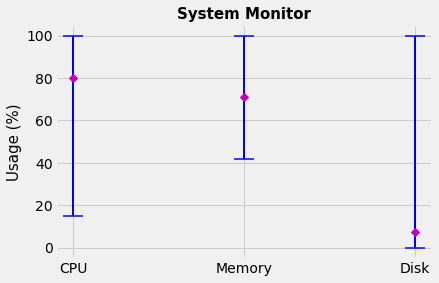

In [3]:
# Visualize CPU, Disk and Memory usage (Min, Max, Current) in a graph

plt.style.use('fivethirtyeight')
plt.errorbar(['CPU', 'Memory', 'Disk'], current_values, [current_values - min_values, max_values - current_values],
             fmt='mD', ecolor='blue', elinewidth=2, label="blah", capsize=10, capthick=1.5)
plt.title('System Monitor', weight='bold', size='15')
plt.ylabel('Usage (%)', size='15')
plt.show()

# Bar Plot of CPU usage (per CPU)
Get the per CPU utilization percentage, by querying each CPU UsePercentage tag. Plot the results.

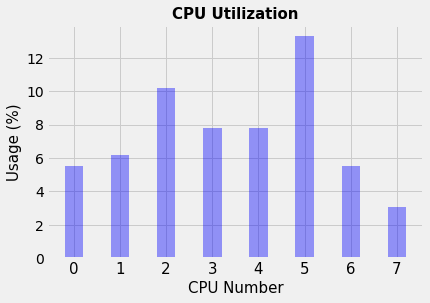

In [4]:
# Visualize CPU usage (%) per CPU

bar_width = 0.4
opacity = 0.4

cpu_count = (await tags_api.get_tags_with_values(path='localhost.Health.CPU.Count')).tags_with_values
num_cpus = int(cpu_count[0].current.value.value)

cpu_tag_lst = ''
i = 0
while (i < num_cpus):
    cpu_tag_lst = cpu_tag_lst + 'localhost.Health.CPU.{}.UsePercentage,'.format(i)
    i = i + 1
cpu_tag_lst = cpu_tag_lst[:-1] # remove trailing comma
cpu_tags = (await tags_api.get_tags_with_values(path=cpu_tag_lst)).tags_with_values

cpu_usage_lst = [float(cpu.current.value.value) for cpu in cpu_tags]
for idx, cpu_usage in enumerate(cpu_usage_lst):
    plt.bar(idx, cpu_usage, bar_width, alpha=opacity, color='b', label=idx)

plt.title('CPU Utilization', weight='bold', size='15')
plt.xlabel('CPU Number', size='15')
plt.ylabel('Usage (%)', size='15')
plt.xticks(range(num_cpus), [str(i) for i in range(num_cpus)], size='15')
plt.show()

# CPU usage history
Plot historic CPU usage values

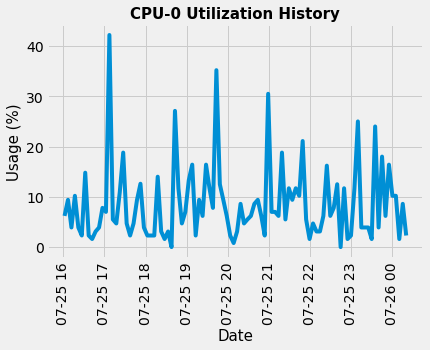

In [5]:
history_api = HistoryApi()
http_query_request = HttpQueryRequestBody(path='localhost.Health.CPU.0.UsePercentage')
res = await history_api.query_history(request_body=http_query_request)
history = [float(cpu.value) for cpu in res.values]
times = [pd.to_datetime(cpu.timestamp) for cpu in res.values]

plt.title('CPU-0 Utilization History', weight='bold', size='15')
plt.xlabel('Date', size='15')
plt.ylabel('Usage (%)', size='15')
plt.plot(times, history)
plt.xticks(rotation='vertical')
plt.show()